# Assignment 2

In this assignment, you will be asked to perform image classification using ResNet-50.

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/DS5660/hw2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, you need to download the training and validation sets from https://github.com/yuankaihuo/DL_course_hw/tree/master/Homework%203/data. 

Save it at the working directory

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import torch
from collections import Counter
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, sampler
from torchvision import models
import torch.nn as nn
from torch.nn.functional import interpolate
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


## Data preparation

In [4]:
# define paths and parameters
traindir = f"data/train"
validdir = f"data/val"

save_file_name = f'resnet50-transfer.pt'
checkpoint_path = f'resnet50-transfer.pth'

# Change to fit hardware
batch_size = 256


In [5]:
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)


Train on gpu: True
1 gpus detected.
True False


In [6]:
# define transforms
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
        transforms.Compose([
            transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=224),  # Image net standards
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])  # Imagenet standards
        ]),
    # Validation does not use augmentation
    'valid':
        transforms.Compose([
            transforms.Resize(size=256),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
}


In [7]:
# take a look at data augmentation

def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

    
ex_img = Image.open('data/train/BEANS/BEANS0001.png')

t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [8]:
# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10)
}

# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

categories = []
for d in os.listdir(traindir):
    categories.append(d)

n_classes = len(categories)
print(f'There are {n_classes} different classes.')

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

There are 25 different classes.


## ResNet modeling

In [9]:
model = models.resnet152(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# print(model)
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

model.fc

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=25, bias=True)
  (4): LogSoftmax(dim=1)
)

58,674,777 total parameters.
530,969 training parameters.


In [10]:
if train_on_gpu:
    model = model.to('cuda')

In [11]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

[(0, 'BEANS'),
 (1, 'CAKE'),
 (2, 'CANDY'),
 (3, 'CEREAL'),
 (4, 'CHIPS'),
 (5, 'CHOCOLATE'),
 (6, 'COFFEE'),
 (7, 'CORN'),
 (8, 'FISH'),
 (9, 'FLOUR')]

torch.Size([256, 2048])
torch.Size([256])
torch.Size([25, 256])
torch.Size([25])


## Training process

In [12]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=10,
          n_epochs=50,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

## Run this on GPU

In [13]:
model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=10,
    n_epochs=50,
    print_every=1)



Starting Training from Scratch.


Epoch: 0 	Training Loss: 2.8853 	Validation Loss: 2.3778
		Training Accuracy: 18.68%	 Validation Accuracy: 34.71%

Epoch: 1 	Training Loss: 2.2611 	Validation Loss: 1.9058
		Training Accuracy: 36.34%	 Validation Accuracy: 50.35%

Epoch: 2 	Training Loss: 1.8605 	Validation Loss: 1.6141
		Training Accuracy: 47.74%	 Validation Accuracy: 58.83%

Epoch: 3 	Training Loss: 1.6287 	Validation Loss: 1.4743
		Training Accuracy: 51.98%	 Validation Accuracy: 57.52%

Epoch: 4 	Training Loss: 1.4851 	Validation Loss: 1.3629
		Training Accuracy: 56.48%	 Validation Accuracy: 59.54%

Epoch: 5 	Training Loss: 1.3958 	Validation Loss: 1.2787
		Training Accuracy: 57.75%	 Validation Accuracy: 61.35%

Epoch: 6 	Training Loss: 1.2993 	Validation Loss: 1.2044
		Training Accuracy: 60.98%	 Validation Accuracy: 63.77%

Epoch: 7 	Training Loss: 1.2272 	Validation Loss: 1.1944
		Training Accuracy: 63.20%	 Validation Accuracy: 62.87%

Epoch: 8 	Training Loss: 1.1974 	Validation Lo

Outcome:  CHOCOLATE  Label:  COFFEE


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff524d2bf28>,
 array([[[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        ...,
 
        [[0.5019608 , 0.5019

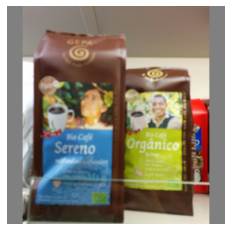

Outcome:  CHIPS  Label:  CAKE


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff524cdccc0>,
 array([[[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        ...,
 
        [[0.5019608 , 0.5019

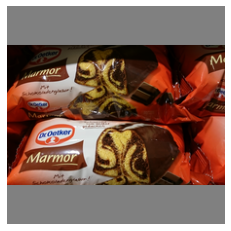

Outcome:  CEREAL  Label:  CAKE


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff524d07160>,
 array([[[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        ...,
 
        [[0.5019608 , 0.5019

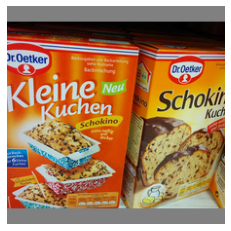

Outcome:  JUICE  Label:  SUGAR


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff524c590f0>,
 array([[[0.19607842, 0.11764705, 0.08627452],
         [0.19999996, 0.12156863, 0.08627452],
         [0.19215684, 0.11764705, 0.08235294],
         ...,
         [0.21568625, 0.15294121, 0.11764705],
         [0.21960783, 0.14901965, 0.11764705],
         [0.21568625, 0.14509806, 0.11372548]],
 
        [[0.19999996, 0.12156863, 0.09019607],
         [0.20784311, 0.1294118 , 0.09803922],
         [0.20784311, 0.12156863, 0.09803922],
         ...,
         [0.20784311, 0.14901965, 0.10980393],
         [0.21568625, 0.14901965, 0.11764705],
         [0.20784311, 0.14117651, 0.10980393]],
 
        [[0.19999996, 0.12156863, 0.08627452],
         [0.20392154, 0.12156863, 0.09411764],
         [0.20392154, 0.11372549, 0.08627452],
         ...,
         [0.20392154, 0.14509806, 0.10980393],
         [0.20392154, 0.14509806, 0.11372548],
         [0.20784311, 0.14509806, 0.11372548]],
 
        ...,
 
        [[0.96862741, 0.8823

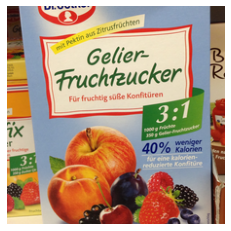

Outcome:  CAKE  Label:  SUGAR


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff524bd99e8>,
 array([[[0.98039216, 0.83921569, 0.47450982],
         [1.        , 0.86274509, 0.38039217],
         [1.        , 0.86666665, 0.3529412 ],
         ...,
         [0.61960784, 0.44313726, 0.27843139],
         [0.65490197, 0.46666667, 0.2901961 ],
         [0.73725489, 0.5529412 , 0.26274512]],
 
        [[1.        , 0.90196078, 0.34509806],
         [0.9960784 , 0.8980392 , 0.33333335],
         [0.9960784 , 0.89019608, 0.32941178],
         ...,
         [0.73333335, 0.61960786, 0.5058824 ],
         [0.71764705, 0.56862748, 0.38039217],
         [0.73725489, 0.55686277, 0.24705882]],
 
        [[0.99215685, 0.8       , 0.24313726],
         [0.9960784 , 0.8       , 0.2392157 ],
         [0.9960784 , 0.8117647 , 0.23529412],
         ...,
         [0.78431371, 0.72156864, 0.62745102],
         [0.74901961, 0.61176473, 0.41568629],
         [0.74509804, 0.56470591, 0.26666668]],
 
        ...,
 
        [[0.63921569, 0.5372

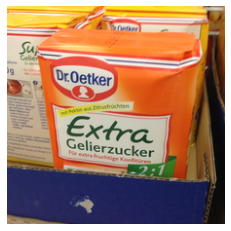

Outcome:  FISH  Label:  SUGAR


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff524baa0b8>,
 array([[[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        ...,
 
        [[0.5019608 , 0.5019

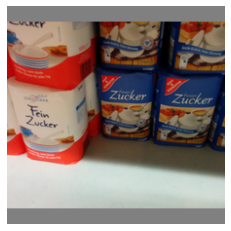

Outcome:  MILK  Label:  SPICES


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff524b6ecf8>,
 array([[[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        ...,
 
        [[0.5019608 , 0.5019

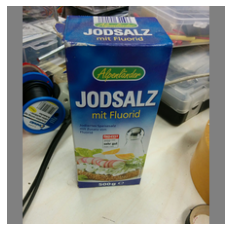

Outcome:  COFFEE  Label:  RICE


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff524b3cd68>,
 array([[[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        ...,
 
        [[0.5019608 , 0.5019

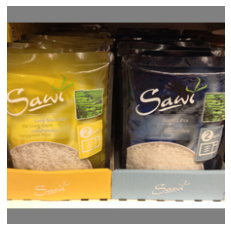

Outcome:  TOMATO_SAUCE  Label:  JUICE


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff524b0dda0>,
 array([[[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        ...,
 
        [[0.5019608 , 0.5019

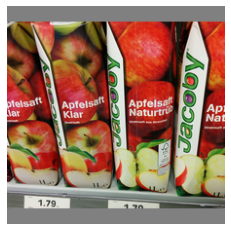

Outcome:  VINEGAR  Label:  OIL


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff524c5a240>,
 array([[[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        [[0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         ...,
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083],
         [0.5019608 , 0.50196081, 0.50196083]],
 
        ...,
 
        [[0.5019608 , 0.5019

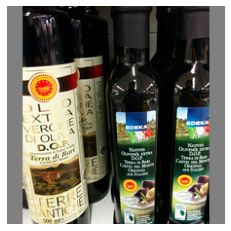

In [14]:
# keep track of training and validation loss each epoch

valid_loss = 0.0
valid_acc = 0   

f1=0
recall=0
precision=0
count=0

results = []  


# Validation loop
for data, target in dataloaders['val']:
    # Tensors to gpu
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    # Forward pass
    output = model(data)

    # Validation loss
    loss = criterion(output, target)
    # Multiply average loss times the number of examples in batch
    valid_loss += loss.item() * data.size(0)

    # Calculate validation accuracy
    _, pred = torch.max(output, dim=1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    accuracy = torch.mean(
        correct_tensor.type(torch.FloatTensor))
    # Multiply average accuracy times the number of examples
    valid_acc += accuracy.item() * data.size(0)
    f1 += f1_score(target.data.view_as(pred).cpu(), pred.cpu(), average='weighted') * data.size(0)
    precision += precision_score(target.data.view_as(pred).cpu(), pred.cpu(), average='weighted') * data.size(0)
    recall += recall_score(target.data.view_as(pred).cpu(), pred.cpu(), average='weighted') * data.size(0)
    



    for i in range(data.size(0)):
        if pred[i] != target[i]:
          count = count+1
          print("Outcome: ", model.idx_to_class[pred.cpu().numpy()[i]], " Label: ", model.idx_to_class[target.cpu().numpy()[i]])
          imshow_tensor(data[i].cpu(), ax=None)
          plt.show()
        if count >=10:
          break 





# Calculate average losses
valid_loss = valid_loss / len(dataloaders['val'].dataset)

# Calculate average accuracy
valid_acc = valid_acc / len(dataloaders['val'].dataset)

f1 = f1 / len(dataloaders['val'].dataset)
recall = recall / len(dataloaders['val'].dataset)
precision = precision / len(dataloaders['val'].dataset)

results.append([ valid_loss, valid_acc, f1, recall, precision])

In [15]:
pd.DataFrame(results,columns=["Validation Loss", "Validation Accuracy", "F1", "Recall", "Precision"])


,Validation Loss,Validation Accuracy,F1,Recall,Precision
0,0.791338,0.754793,0.755037,0.754793,0.780915


## Visualize results

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

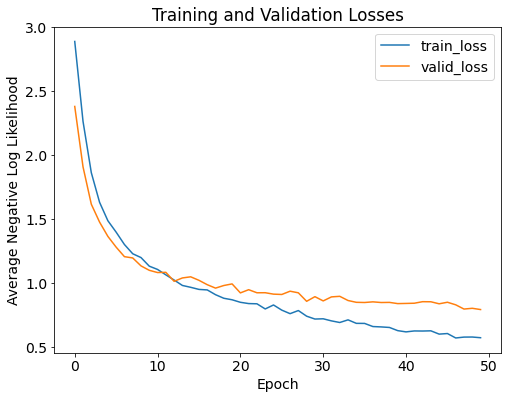

In [16]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

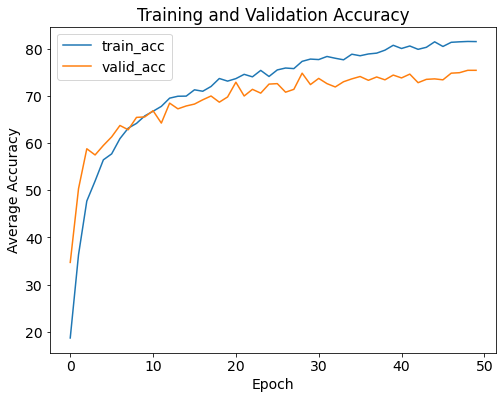

In [17]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

## Save results

In [18]:
torch.save(model.state_dict(), 'best_model.pt')

model.load_state_dict(torch.load('best_model.pt'))

history.to_csv("history.csv",index=False)


<All keys matched successfully>

## ResNet 18 Modification 

# 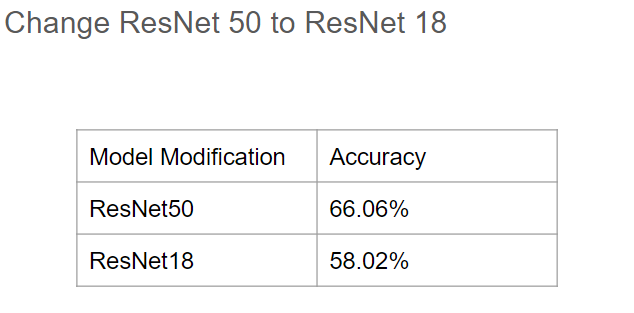

## MSE Modification 

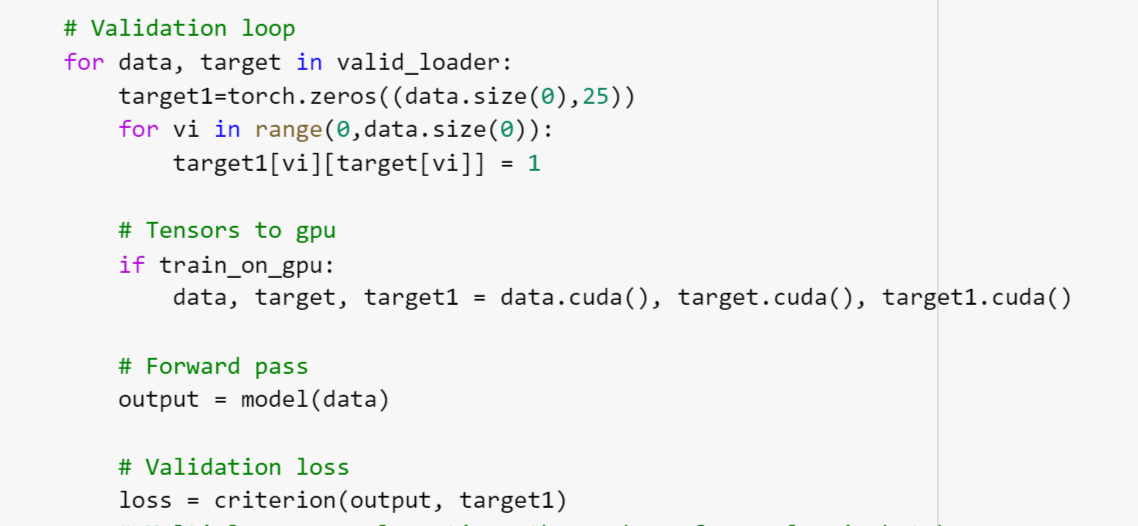

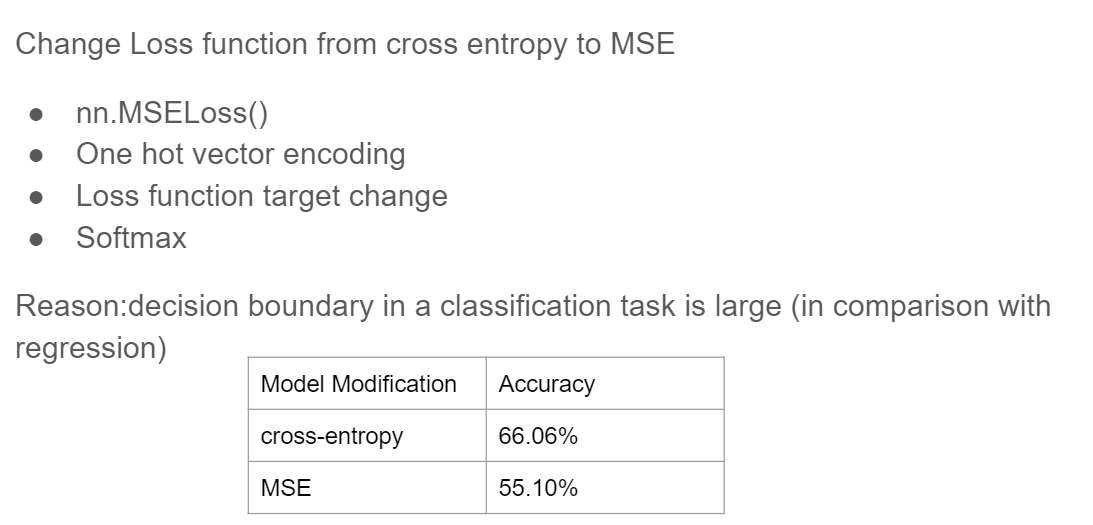

## Grading

When you submit the homework, please upload your Colab notebook either in its original `ipynb` format, or `pdf` (preferred) 

Your homework will be graded A, B, or F.

### 4.1 B <a name="b"></a>

* Follow along the template, and get all outputs 

### 4.2 F <a name="f"></a>

* Fail to submit homework on time, or  

* Fail to reproduce all the results from template  

### 4.3 A <a name="a"></a>

* Follow along the template, fine-tune ResNET model, and achieve a validation accuracy of 70% and above   

* If you decide to fine-tune the model, please make it explicit where you made the changes.  